## Problem: Flag the junk property listings
As the real estate becomes a scarce commodity in big cities of the world; renovating old properties for sale is becoming a thriving business. However, not every property becomes an attractive portfolio after tons of time, money and effort goes into giving it a second life. Reasons can be its location , condition being too dilapidated or simply the neighbourhood having lost it lustre of the olden days. These things are not very difficult to figure out after a thorough assessment. But by the time that assessment is over; a lot of time , manpower and money is lost, which makes the overall endeavour at times resulting in crippling loss for this upcoming branch of alternative business opportunity for real estate industry.

Flagging a property as possibly junk before hand can help businesses prioritise their efforts and focus them on the more probable successes rather than bogged down with the weight of unsaleable portfolio.

In this project we will be making use of data from such past operations where many properties were found to be junk after their purchase for renovations. Our task is to predict if a property is going to be unfit using its listing details and other features which are part of first preliminary assessment.

### observation: 
supervised :classication problem

In [1]:
# importing the libraries 
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None) 

In [2]:
# reading the csv files
datafile_train="Property_train.csv"
datafile_test="Property_test_share.csv"
bd_train=pd.read_csv(datafile_train)
bd_test=pd.read_csv(datafile_test) 

In [3]:
# sample train data
bd_train.head()

,Junk,InteriorsStyle,PriceIndex8,ListDate,Material,PriceIndex9,Agency,AreaIncomeType,EnvRating,PriceIndex7,ExpeditedListing,PriceIndex4,PriceIndex1,PriceIndex6,PRIMEUNIT,Channel,Zip,InsurancePremiumIndex,PlotType,Architecture,PriceIndex3,Region,PriceIndex5,SubModel,Facade,State,NormalisedPopulation,BuildYear,RegionType,PropertyAge,PriceIndex2
0,0,6LLJ,14674.0,9/7/2010,UT7W,8270,CAT3,B,missing,13143.0,0,14224.0,9217.0,10387.0,missing,Direct,21075,623,WHBI,I3Z9,13108.0,A,9022.0,6E9G,GREEN,MD,42077,2008,A,2,10692.0
1,1,XZ9F,4172.0,1/7/2009,PRN0,3890,CAT2,B,missing,3461.0,0,4404.0,2958.0,3400.0,missing,Direct,73129,1689,WHBI,AVYP,3695.0,A,2742.0,FIVQ,SILVER,OK,77258,2002,A,7,3615.0
2,0,QWEV,8210.0,6/23/2010,A9RA,5900,CAT1,B,missing,6922.0,0,8952.0,4568.0,4862.0,missing,Other,29697,2351,W62B,1M5X,7730.0,A,3768.0,4K0H,SILVER,SC,94514,2004,A,6,5805.0
3,0,MK2K,7309.0,3/19/2009,RRJQ,7460,OTHER,A,missing,6300.0,0,7460.0,5361.0,6305.0,missing,Agent,28273,1933,WLQ6,DKOO,6290.0,A,5370.0,ZLXY,WHITE,NC,82302,2002,C,7,6444.0
4,0,GK4G,9182.0,3/3/2010,HE5A,6400,OTHER,B,missing,8330.0,0,9846.0,5428.0,5718.0,missing,Other,29697,482,WHBI,KML6,8583.0,A,4803.0,FIVQ,SILVER,SC,49176,2007,B,3,6286.0


In [4]:
# "Junk" feature value counts
target='Junk'
bd_train[target].value_counts() 

Junk
0    54433
1     7602
Name: count, dtype: int64

**data is imbalanced.**

In [5]:
## some variables are stored as categorical but need to be treated as numeric [PriceIndex8 etc.]. 
## And some which are stored as numeric but are representing categorical information [such as Zip etc.]
bd_train.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62035 entries, 0 to 62034
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Junk                   62035 non-null  int64 
 1   InteriorsStyle         62035 non-null  object
 2   PriceIndex8            62035 non-null  object
 3   ListDate               62035 non-null  object
 4   Material               62035 non-null  object
 5   PriceIndex9            62035 non-null  int64 
 6   Agency                 62035 non-null  object
 7   AreaIncomeType         62035 non-null  object
 8   EnvRating              62035 non-null  object
 9   PriceIndex7            62035 non-null  object
 10  ExpeditedListing       62035 non-null  int64 
 11  PriceIndex4            62035 non-null  object
 12  PriceIndex1            62035 non-null  object
 13  PriceIndex6            62035 non-null  object
 14  PRIMEUNIT              62035 non-null  object
 15  Channel            

### data preprocessing:
-  "PriceIndex1" to "PriceIndex8": should be convert into numeric data type.
-  "ListDate" is converted into datatime data type and create cyclic features from cyclic components and delet the column
-  columns:"Zip" was represented as numeric but they are categorical.
-  creat the dummies for categorical columns

In [6]:
# creating a target column: "junk" with nan values in test dataset
# to combining the train & test data for data preprocessing
target='Junk'
bd_test[target]=np.nan 

In [7]:
# rearranging the columns in test data according to train data
bd_test=bd_test[list(bd_train.columns)]

In [8]:
# creating new column "data" with values:'train' & 'test'
bd_train['data']='train'
bd_test['data']='test'

#combining the train and test data for data preprocessing
all_data=pd.concat([bd_train,bd_test],axis=0,sort=False)

In [9]:
# size of the combined data
all_data.shape

(72983, 32)

In [10]:
# some null values present in the data after converting into numeric column.
# we need to impute the null values with mean values of train data
pd.to_numeric(all_data['PriceIndex1'],errors='coerce').isnull().sum()

18

In [11]:
## converting categorical columns 'PriceIndex' to numeric 

# creating list with column names 
cat_to_numeric=['PriceIndex'+str(i) for i in range(1,10)] 

# converting the columns into numeric
for col in cat_to_numeric:
    
    # converting into numeric datatype
    all_data[col]=pd.to_numeric(all_data[col],errors='coerce')
    
    # filling "nan" values with median of train data
    all_data[col]=all_data[col].fillna(all_data.loc[all_data['data']=='train',col].median())

In [12]:
# priceindex are converted to numeric
all_data.info()  

<class 'pandas.core.frame.DataFrame'>
Index: 72983 entries, 0 to 10947
Data columns (total 32 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Junk                   62035 non-null  float64
 1   InteriorsStyle         72983 non-null  object 
 2   PriceIndex8            72983 non-null  float64
 3   ListDate               72983 non-null  object 
 4   Material               72983 non-null  object 
 5   PriceIndex9            72983 non-null  int64  
 6   Agency                 72983 non-null  object 
 7   AreaIncomeType         72983 non-null  object 
 8   EnvRating              72983 non-null  object 
 9   PriceIndex7            72983 non-null  float64
 10  ExpeditedListing       72983 non-null  int64  
 11  PriceIndex4            72983 non-null  float64
 12  PriceIndex1            72983 non-null  float64
 13  PriceIndex6            72983 non-null  float64
 14  PRIMEUNIT              72983 non-null  object 
 15  Channel

**we should extract components from column:"ListDate" and use them as features.**

day of  week; 0: monday to 6: sunday

In [13]:
# importing the libraries
from datetime import date

# creating new features from 'ListDate'
all_data['ListDate_year']=pd.to_datetime(all_data['ListDate']).dt.year
all_data['ListDate_month']=pd.to_datetime(all_data['ListDate']).dt.month
all_data['ListDate_dayofmonth']=pd.to_datetime(all_data['ListDate']).dt.day
all_data['ListDate_day_of_week']=pd.to_datetime(all_data['ListDate']).dt.day_of_week 

In [14]:
# creating cyclic components from cyclic features:
# 'ListDate_month','ListDate_dayofmonth','ListDate_weekofyear','ListDate_day_of_week'  and delet them after the process
all_data['ListDate_month_cy_s']=np.sin(2*np.pi*all_data['ListDate_month']/12) 
all_data['ListDate_month_cy_c']=np.cos(2*np.pi*all_data['ListDate_month']/12)

all_data['ListDate_dayofmonth_cy_s']=np.sin(2*np.pi*all_data['ListDate_dayofmonth']/31)
all_data['ListDate_dayofmonth_cy_c']=np.cos(2*np.pi*all_data['ListDate_dayofmonth']/31)

all_data['ListDate_dayofweek_cy_s']=np.sin(2*np.pi*all_data['ListDate_day_of_week']/6)
all_data['ListDate_dayofweek_cy_c']=np.cos(2*np.pi*all_data['ListDate_day_of_week']/6) 

# deleting the cyclic features
all_data_cy=all_data.drop(['ListDate','ListDate_month','ListDate_dayofmonth','ListDate_day_of_week'],axis=1)
all_data_cy.head()

,Junk,InteriorsStyle,PriceIndex8,Material,PriceIndex9,Agency,AreaIncomeType,EnvRating,PriceIndex7,ExpeditedListing,PriceIndex4,PriceIndex1,PriceIndex6,PRIMEUNIT,Channel,Zip,InsurancePremiumIndex,PlotType,Architecture,PriceIndex3,Region,PriceIndex5,SubModel,Facade,State,NormalisedPopulation,BuildYear,RegionType,PropertyAge,PriceIndex2,data,ListDate_year,ListDate_month_cy_s,ListDate_month_cy_c,ListDate_dayofmonth_cy_s,ListDate_dayofmonth_cy_c,ListDate_dayofweek_cy_s,ListDate_dayofweek_cy_c
0,0.0,6LLJ,14674.0,UT7W,8270,CAT3,B,missing,13143.0,0,14224.0,9217.0,10387.0,missing,Direct,21075,623,WHBI,I3Z9,13108.0,A,9022.0,6E9G,GREEN,MD,42077,2008,A,2,10692.0,train,2010,-1.000000e+00,-1.836970e-16,0.988468,0.151428,8.660254e-01,0.5
1,1.0,XZ9F,4172.0,PRN0,3890,CAT2,B,missing,3461.0,0,4404.0,2958.0,3400.0,missing,Direct,73129,1689,WHBI,AVYP,3695.0,A,2742.0,FIVQ,SILVER,OK,77258,2002,A,7,3615.0,train,2009,5.000000e-01,8.660254e-01,0.988468,0.151428,8.660254e-01,-0.5
2,0.0,QWEV,8210.0,A9RA,5900,CAT1,B,missing,6922.0,0,8952.0,4568.0,4862.0,missing,Other,29697,2351,W62B,1M5X,7730.0,A,3768.0,4K0H,SILVER,SC,94514,2004,A,6,5805.0,train,2010,1.224647e-16,-1.000000e+00,-0.998717,-0.050649,8.660254e-01,-0.5
3,0.0,MK2K,7309.0,RRJQ,7460,OTHER,A,missing,6300.0,0,7460.0,5361.0,6305.0,missing,Agent,28273,1933,WLQ6,DKOO,6290.0,A,5370.0,ZLXY,WHITE,NC,82302,2002,C,7,6444.0,train,2009,1.000000e+00,6.123234e-17,-0.651372,-0.758758,1.224647e-16,-1.0
4,0.0,GK4G,9182.0,HE5A,6400,OTHER,B,missing,8330.0,0,9846.0,5428.0,5718.0,missing,Other,29697,482,WHBI,KML6,8583.0,A,4803.0,FIVQ,SILVER,SC,49176,2007,B,3,6286.0,train,2010,1.000000e+00,6.123234e-17,0.571268,0.820763,8.660254e-01,-0.5


In [15]:
# selectig the categorical/object datatype column from the total data and checking the nuinque value in the each column
all_data_cy.select_dtypes('O').describe() 

,InteriorsStyle,Material,Agency,AreaIncomeType,EnvRating,PRIMEUNIT,Channel,PlotType,Architecture,Region,SubModel,Facade,State,RegionType,data
count,72983,72983,72983,72983,72983,72983,72983,72983,72983,72983,72983,72983,72983,72983,72983
unique,1063,135,5,4,3,3,3,13,33,3,864,17,37,5,2
top,K3BB,PRN0,CAT1,A,missing,missing,Direct,WHBI,YIK5,A,FIVQ,SILVER,TX,A,train
freq,2329,13950,25314,36050,69564,69564,41043,30785,17248,70398,15236,14875,13596,61028,62035


In [16]:
all_data_cy['EnvRating'].value_counts() 

EnvRating
missing    69564
GREEN       3340
RED           79
Name: count, dtype: int64

In [17]:
all_data_cy['PRIMEUNIT'].value_counts()

PRIMEUNIT
missing    69564
NO          3357
YES           62
Name: count, dtype: int64

**Large no of missing values present in the columns:"EnvRating" and "PRIMEUNIT". so, "missing" value is treated as new category instead of removing the entire column.**

In [18]:
all_data_cy.select_dtypes('O').columns

Index(['InteriorsStyle', 'Material', 'Agency', 'AreaIncomeType', 'EnvRating',
       'PRIMEUNIT', 'Channel', 'PlotType', 'Architecture', 'Region',
       'SubModel', 'Facade', 'State', 'RegionType', 'data'],
      dtype='object')

In [19]:
# list of categorical columns
# columns:['Zip','ListDate_year' ] are represented as numeric but they are categorical

cat_cols=['InteriorsStyle','Material', 'Agency', 'AreaIncomeType',
       'EnvRating', 'PRIMEUNIT', 'Channel', 'PlotType', 'Architecture',
       'Region', 'SubModel', 'Facade', 'State', 'RegionType','Zip','ListDate_year'] 

In [20]:
# creating dummies for categorical columns based on frequency count >700(1% data)
for col in cat_cols:
    
    # computing no of unique values and teir frequecy 
    k=all_data_cy[col].value_counts()
    # selecting unique values with frequency>700 and 
    # ignoring the last value to avoid multicollinearity
    cats=k[k>=700].index[:-1]
    
    # creating dummies for each unique value
    for cat in cats:
        # creating dummy column with name: column_uniqueValue
        name=col+'_'+str(cat)
        all_data_cy[name]=(all_data_cy[col]==cat).astype(int)
        
    # deleting the column after creating dummies    
    del all_data_cy[col]

In [21]:
# droping the 'BuildYear' b/z its already capture in property age.
all_data_cy.drop(['BuildYear'],axis=1,inplace=True)

In [22]:
all_data_cy.head() 

,Junk,PriceIndex8,PriceIndex9,PriceIndex7,ExpeditedListing,PriceIndex4,PriceIndex1,PriceIndex6,InsurancePremiumIndex,PriceIndex3,PriceIndex5,NormalisedPopulation,PropertyAge,PriceIndex2,data,ListDate_month_cy_s,ListDate_month_cy_c,ListDate_dayofmonth_cy_s,ListDate_dayofmonth_cy_c,ListDate_dayofweek_cy_s,ListDate_dayofweek_cy_c,InteriorsStyle_K3BB,InteriorsStyle_RCQE,InteriorsStyle_WEGU,InteriorsStyle_2XWO,InteriorsStyle_V3Y1,InteriorsStyle_YBQJ,InteriorsStyle_AZMX,InteriorsStyle_DUFA,InteriorsStyle_7R8J,InteriorsStyle_H1CI,InteriorsStyle_ARWN,InteriorsStyle_T67A,InteriorsStyle_F59U,InteriorsStyle_Y4AM,InteriorsStyle_QWEV,InteriorsStyle_RZ14,InteriorsStyle_J20T,InteriorsStyle_7NL9,Material_PRN0,Material_C8A4,Material_ZCI3,Material_NYFD,Material_X7IX,Material_IKAF,Material_HE5A,Material_4ZHP,Material_RRJQ,Material_2NHM,Material_OZMT,Material_H5XT,Material_ARWN,Material_WO6R,Material_NCCU,Material_JD5J,Material_1MJN,Material_A9RA,Material_1PUV,Material_MCPM,Agency_CAT1,Agency_CAT2,Agency_CAT3,AreaIncomeType_A,AreaIncomeType_B,AreaIncomeType_missing,EnvRating_missing,PRIMEUNIT_missing,Channel_Direct,Channel_Other,PlotType_WHBI,PlotType_W62B,PlotType_32T2,PlotType_DIJX,PlotType_WLQ6,PlotType_DSSM,PlotType_DJOP,PlotType_7RBQ,PlotType_I00H,PlotType_V5R0,PlotType_8FRL,Architecture_YIK5,Architecture_TP7R,Architecture_I3Z9,Architecture_AVYP,Architecture_1M5X,Architecture_4GZ4,Architecture_7IYX,Architecture_RZOR,Architecture_8SPA,Architecture_K92H,Architecture_KML6,Architecture_M3C0,Architecture_5NBT,Architecture_RIAX,Architecture_STJH,Region_A,SubModel_FIVQ,SubModel_KT8F,SubModel_UA42,SubModel_8YTZ,SubModel_GR5P,SubModel_K8LM,SubModel_ASW2,SubModel_TMA3,SubModel_GXUO,SubModel_XHI5,SubModel_E75G,SubModel_IAQO,Facade_SILVER,Facade_WHITE,Facade_BLUE,Facade_GREY,Facade_BLACK,Facade_RED,Facade_GOLD,Facade_GREEN,Facade_MAROON,State_TX,State_FL,State_CA,State_NC,State_AZ,State_CO,State_SC,State_OK,State_GA,State_TN,State_VA,State_MD,State_UT,State_PA,State_OH,RegionType_A,RegionType_B,Zip_32824,Zip_27542,Zip_75236,Zip_74135,Zip_80022,Zip_85226,Zip_85040,Zip_29697,Zip_95673,Zip_28273,Zip_33619,Zip_29532,Zip_75050,Zip_76040,Zip_77041,Zip_78754,Zip_80011,Zip_73108,Zip_28625,Zip_91752,Zip_78219,Zip_30272,Zip_32124,Zip_92807,Zip_21075,Zip_77086,Zip_78227,Zip_80817,Zip_34761,Zip_85009,Zip_92337,Zip_45005,Zip_94544,Zip_80229,ListDate_year_2010
0,0.0,14674.0,8270,13143.0,0,14224.0,9217.0,10387.0,623,13108.0,9022.0,42077,2,10692.0,train,-1.000000e+00,-1.836970e-16,0.988468,0.151428,8.660254e-01,0.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
1,1.0,4172.0,3890,3461.0,0,4404.0,2958.0,3400.0,1689,3695.0,2742.0,77258,7,3615.0,train,5.000000e-01,8.660254e-01,0.988468,0.151428,8.660254e-01,-0.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0.0,8210.0,5900,6922.0,0,8952.0,4568.0,4862.0,2351,7730.0,3768.0,94514,6,5805.0,train,1.224647e-16,-1.000000e+00,-0.998717,-0.050649,8.660254e-01,-0.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0.0,7309.0,7460,6300.0,0,7460.0,5361.0,6305.0,1933,6290.0,5370.0,82302,7,6444.0,train,1.000000e+00,6.123234e-17,-0.651372,-0.758758,1.224647e-16,-1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [23]:
## spliting the data into train(x_train, y_train) and test(x_test)
# train data
x_train=all_data_cy.drop([target,'data'],axis=1)[all_data_cy['data']=='train']
y_train=all_data_cy[target][all_data_cy['data']=='train']
# test data
x_test=all_data_cy.drop([target,'data'],axis=1)[all_data_cy['data']=='test']

In [24]:
# x_train data set
x_train.head() 

,PriceIndex8,PriceIndex9,PriceIndex7,ExpeditedListing,PriceIndex4,PriceIndex1,PriceIndex6,InsurancePremiumIndex,PriceIndex3,PriceIndex5,NormalisedPopulation,PropertyAge,PriceIndex2,ListDate_month_cy_s,ListDate_month_cy_c,ListDate_dayofmonth_cy_s,ListDate_dayofmonth_cy_c,ListDate_dayofweek_cy_s,ListDate_dayofweek_cy_c,InteriorsStyle_K3BB,InteriorsStyle_RCQE,InteriorsStyle_WEGU,InteriorsStyle_2XWO,InteriorsStyle_V3Y1,InteriorsStyle_YBQJ,InteriorsStyle_AZMX,InteriorsStyle_DUFA,InteriorsStyle_7R8J,InteriorsStyle_H1CI,InteriorsStyle_ARWN,InteriorsStyle_T67A,InteriorsStyle_F59U,InteriorsStyle_Y4AM,InteriorsStyle_QWEV,InteriorsStyle_RZ14,InteriorsStyle_J20T,InteriorsStyle_7NL9,Material_PRN0,Material_C8A4,Material_ZCI3,Material_NYFD,Material_X7IX,Material_IKAF,Material_HE5A,Material_4ZHP,Material_RRJQ,Material_2NHM,Material_OZMT,Material_H5XT,Material_ARWN,Material_WO6R,Material_NCCU,Material_JD5J,Material_1MJN,Material_A9RA,Material_1PUV,Material_MCPM,Agency_CAT1,Agency_CAT2,Agency_CAT3,AreaIncomeType_A,AreaIncomeType_B,AreaIncomeType_missing,EnvRating_missing,PRIMEUNIT_missing,Channel_Direct,Channel_Other,PlotType_WHBI,PlotType_W62B,PlotType_32T2,PlotType_DIJX,PlotType_WLQ6,PlotType_DSSM,PlotType_DJOP,PlotType_7RBQ,PlotType_I00H,PlotType_V5R0,PlotType_8FRL,Architecture_YIK5,Architecture_TP7R,Architecture_I3Z9,Architecture_AVYP,Architecture_1M5X,Architecture_4GZ4,Architecture_7IYX,Architecture_RZOR,Architecture_8SPA,Architecture_K92H,Architecture_KML6,Architecture_M3C0,Architecture_5NBT,Architecture_RIAX,Architecture_STJH,Region_A,SubModel_FIVQ,SubModel_KT8F,SubModel_UA42,SubModel_8YTZ,SubModel_GR5P,SubModel_K8LM,SubModel_ASW2,SubModel_TMA3,SubModel_GXUO,SubModel_XHI5,SubModel_E75G,SubModel_IAQO,Facade_SILVER,Facade_WHITE,Facade_BLUE,Facade_GREY,Facade_BLACK,Facade_RED,Facade_GOLD,Facade_GREEN,Facade_MAROON,State_TX,State_FL,State_CA,State_NC,State_AZ,State_CO,State_SC,State_OK,State_GA,State_TN,State_VA,State_MD,State_UT,State_PA,State_OH,RegionType_A,RegionType_B,Zip_32824,Zip_27542,Zip_75236,Zip_74135,Zip_80022,Zip_85226,Zip_85040,Zip_29697,Zip_95673,Zip_28273,Zip_33619,Zip_29532,Zip_75050,Zip_76040,Zip_77041,Zip_78754,Zip_80011,Zip_73108,Zip_28625,Zip_91752,Zip_78219,Zip_30272,Zip_32124,Zip_92807,Zip_21075,Zip_77086,Zip_78227,Zip_80817,Zip_34761,Zip_85009,Zip_92337,Zip_45005,Zip_94544,Zip_80229,ListDate_year_2010
0,14674.0,8270,13143.0,0,14224.0,9217.0,10387.0,623,13108.0,9022.0,42077,2,10692.0,-1.000000e+00,-1.836970e-16,0.988468,0.151428,8.660254e-01,0.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
1,4172.0,3890,3461.0,0,4404.0,2958.0,3400.0,1689,3695.0,2742.0,77258,7,3615.0,5.000000e-01,8.660254e-01,0.988468,0.151428,8.660254e-01,-0.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,8210.0,5900,6922.0,0,8952.0,4568.0,4862.0,2351,7730.0,3768.0,94514,6,5805.0,1.224647e-16,-1.000000e+00,-0.998717,-0.050649,8.660254e-01,-0.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,7309.0,7460,6300.0,0,7460.0,5361.0,6305.0,1933,6290.0,5370.0,82302,7,6444.0,1.000000e+00,6.123234e-17,-0.651372,-0.758758,1.224647e-16,-1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0

In [25]:
# x_test data set
x_test.head() 

,PriceIndex8,PriceIndex9,PriceIndex7,ExpeditedListing,PriceIndex4,PriceIndex1,PriceIndex6,InsurancePremiumIndex,PriceIndex3,PriceIndex5,NormalisedPopulation,PropertyAge,PriceIndex2,ListDate_month_cy_s,ListDate_month_cy_c,ListDate_dayofmonth_cy_s,ListDate_dayofmonth_cy_c,ListDate_dayofweek_cy_s,ListDate_dayofweek_cy_c,InteriorsStyle_K3BB,InteriorsStyle_RCQE,InteriorsStyle_WEGU,InteriorsStyle_2XWO,InteriorsStyle_V3Y1,InteriorsStyle_YBQJ,InteriorsStyle_AZMX,InteriorsStyle_DUFA,InteriorsStyle_7R8J,InteriorsStyle_H1CI,InteriorsStyle_ARWN,InteriorsStyle_T67A,InteriorsStyle_F59U,InteriorsStyle_Y4AM,InteriorsStyle_QWEV,InteriorsStyle_RZ14,InteriorsStyle_J20T,InteriorsStyle_7NL9,Material_PRN0,Material_C8A4,Material_ZCI3,Material_NYFD,Material_X7IX,Material_IKAF,Material_HE5A,Material_4ZHP,Material_RRJQ,Material_2NHM,Material_OZMT,Material_H5XT,Material_ARWN,Material_WO6R,Material_NCCU,Material_JD5J,Material_1MJN,Material_A9RA,Material_1PUV,Material_MCPM,Agency_CAT1,Agency_CAT2,Agency_CAT3,AreaIncomeType_A,AreaIncomeType_B,AreaIncomeType_missing,EnvRating_missing,PRIMEUNIT_missing,Channel_Direct,Channel_Other,PlotType_WHBI,PlotType_W62B,PlotType_32T2,PlotType_DIJX,PlotType_WLQ6,PlotType_DSSM,PlotType_DJOP,PlotType_7RBQ,PlotType_I00H,PlotType_V5R0,PlotType_8FRL,Architecture_YIK5,Architecture_TP7R,Architecture_I3Z9,Architecture_AVYP,Architecture_1M5X,Architecture_4GZ4,Architecture_7IYX,Architecture_RZOR,Architecture_8SPA,Architecture_K92H,Architecture_KML6,Architecture_M3C0,Architecture_5NBT,Architecture_RIAX,Architecture_STJH,Region_A,SubModel_FIVQ,SubModel_KT8F,SubModel_UA42,SubModel_8YTZ,SubModel_GR5P,SubModel_K8LM,SubModel_ASW2,SubModel_TMA3,SubModel_GXUO,SubModel_XHI5,SubModel_E75G,SubModel_IAQO,Facade_SILVER,Facade_WHITE,Facade_BLUE,Facade_GREY,Facade_BLACK,Facade_RED,Facade_GOLD,Facade_GREEN,Facade_MAROON,State_TX,State_FL,State_CA,State_NC,State_AZ,State_CO,State_SC,State_OK,State_GA,State_TN,State_VA,State_MD,State_UT,State_PA,State_OH,RegionType_A,RegionType_B,Zip_32824,Zip_27542,Zip_75236,Zip_74135,Zip_80022,Zip_85226,Zip_85040,Zip_29697,Zip_95673,Zip_28273,Zip_33619,Zip_29532,Zip_75050,Zip_76040,Zip_77041,Zip_78754,Zip_80011,Zip_73108,Zip_28625,Zip_91752,Zip_78219,Zip_30272,Zip_32124,Zip_92807,Zip_21075,Zip_77086,Zip_78227,Zip_80817,Zip_34761,Zip_85009,Zip_92337,Zip_45005,Zip_94544,Zip_80229,ListDate_year_2010
0,10645.0,6015,9568.0,0,12432.0,6986.0,7133.0,728,10860.0,5911.0,67549,4,8311.0,-1.000000,-1.836970e-16,-0.968077,-0.250653,8.660254e-01,-0.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,9891.0,7625,8888.0,0,12173.0,5954.0,6544.0,1334,10166.0,5370.0,56570,6,7123.0,1.000000,6.123234e-17,0.651372,-0.758758,-8.660254e-01,-0.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,8426.0,6900,7911.0,0,9134.0,7407.0,7339.0,754,8500.0,6862.0,51840,1,7994.0,-0.866025,5.000000e-01,0.651372,-0.758758,0.000000e+00,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,9269.0,6475,7773.0,0,8500.0,4241.0,6143.0,1373,7294.0,4872.0,83300,5,5259.0,0.500000,-8.660254e-01,-0.790776,-0.612106,1.224647e-16,-1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1

In [26]:
# data size
x_train.shape,x_test.shape

((62035, 167), (10948, 167))

### Normalizing the data using "StandardScaler":

In [27]:
# importing the libraries
from sklearn.preprocessing import StandardScaler
std=StandardScaler()
# transforming the data
x_train_std=pd.DataFrame(std.fit_transform(x_train),columns=x_train.columns)
x_test_std=pd.DataFrame(std.transform(x_test),columns=x_train.columns)

In [28]:
# standardised train data
x_train_std.head()   

,PriceIndex8,PriceIndex9,PriceIndex7,ExpeditedListing,PriceIndex4,PriceIndex1,PriceIndex6,InsurancePremiumIndex,PriceIndex3,PriceIndex5,NormalisedPopulation,PropertyAge,PriceIndex2,ListDate_month_cy_s,ListDate_month_cy_c,ListDate_dayofmonth_cy_s,ListDate_dayofmonth_cy_c,ListDate_dayofweek_cy_s,ListDate_dayofweek_cy_c,InteriorsStyle_K3BB,InteriorsStyle_RCQE,InteriorsStyle_WEGU,InteriorsStyle_2XWO,InteriorsStyle_V3Y1,InteriorsStyle_YBQJ,InteriorsStyle_AZMX,InteriorsStyle_DUFA,InteriorsStyle_7R8J,InteriorsStyle_H1CI,InteriorsStyle_ARWN,InteriorsStyle_T67A,InteriorsStyle_F59U,InteriorsStyle_Y4AM,InteriorsStyle_QWEV,InteriorsStyle_RZ14,InteriorsStyle_J20T,InteriorsStyle_7NL9,Material_PRN0,Material_C8A4,Material_ZCI3,Material_NYFD,Material_X7IX,Material_IKAF,Material_HE5A,Material_4ZHP,Material_RRJQ,Material_2NHM,Material_OZMT,Material_H5XT,Material_ARWN,Material_WO6R,Material_NCCU,Material_JD5J,Material_1MJN,Material_A9RA,Material_1PUV,Material_MCPM,Agency_CAT1,Agency_CAT2,Agency_CAT3,AreaIncomeType_A,AreaIncomeType_B,AreaIncomeType_missing,EnvRating_missing,PRIMEUNIT_missing,Channel_Direct,Channel_Other,PlotType_WHBI,PlotType_W62B,PlotType_32T2,PlotType_DIJX,PlotType_WLQ6,PlotType_DSSM,PlotType_DJOP,PlotType_7RBQ,PlotType_I00H,PlotType_V5R0,PlotType_8FRL,Architecture_YIK5,Architecture_TP7R,Architecture_I3Z9,Architecture_AVYP,Architecture_1M5X,Architecture_4GZ4,Architecture_7IYX,Architecture_RZOR,Architecture_8SPA,Architecture_K92H,Architecture_KML6,Architecture_M3C0,Architecture_5NBT,Architecture_RIAX,Architecture_STJH,Region_A,SubModel_FIVQ,SubModel_KT8F,SubModel_UA42,SubModel_8YTZ,SubModel_GR5P,SubModel_K8LM,SubModel_ASW2,SubModel_TMA3,SubModel_GXUO,SubModel_XHI5,SubModel_E75G,SubModel_IAQO,Facade_SILVER,Facade_WHITE,Facade_BLUE,Facade_GREY,Facade_BLACK,Facade_RED,Facade_GOLD,Facade_GREEN,Facade_MAROON,State_TX,State_FL,State_CA,State_NC,State_AZ,State_CO,State_SC,State_OK,State_GA,State_TN,State_VA,State_MD,State_UT,State_PA,State_OH,RegionType_A,RegionType_B,Zip_32824,Zip_27542,Zip_75236,Zip_74135,Zip_80022,Zip_85226,Zip_85040,Zip_29697,Zip_95673,Zip_28273,Zip_33619,Zip_29532,Zip_75050,Zip_76040,Zip_77041,Zip_78754,Zip_80011,Zip_73108,Zip_28625,Zip_91752,Zip_78219,Zip_30272,Zip_32124,Zip_92807,Zip_21075,Zip_77086,Zip_78227,Zip_80817,Zip_34761,Zip_85009,Zip_92337,Zip_45005,Zip_94544,Zip_80229,ListDate_year_2010
0,1.371118,0.871152,1.415564,-0.159073,1.290690,1.253001,1.117921,-1.089057,1.458819,1.189190,-2.015070,-1.270922,1.218428,-1.351958,-0.009532,1.402901,0.314495,0.734737,1.038216,-0.183086,-0.168516,-0.142168,-0.137799,-0.13442,-0.130897,-0.126364,-0.127021,-0.12357,-0.123031,-0.124107,-0.120784,-0.117655,-0.111443,-0.111887,-0.109424,-0.106521,-0.099901,-0.487423,-0.402719,-0.383062,-0.234289,-0.224953,-0.185005,-0.182191,-0.178282,-0.173163,-0.137616,-0.136579,-0.13967,-0.131151,-0.129359,-0.115524,-0.1107,-0.107753,-0.106521,-0.104333,-0.10354,-0.729456,-0.686269,2.221154,-0.985516,1.097146,-0.212324,0.223167,0.223167,0.884192,-0.563506,1.169353,-0.372867,-0.352,-0.330625,-0.295374,-0.213524,-0.177896,-0.165199,-0.155413,-0.142227,-0.108592,-0.555931,-0.46267,2.339395,-0.372054,-0.250323,-0.186954,-0.175129,-0.170529,-0.161243,-0.150948,-0.136273,-0.125107,-0.121058,-0.117161,-0.113574,0.190208,-0.515095,-0.262954,-0.236463,-0.177462,-0.133672,-0.128584,-0.123839,-0.123973,-0.121127,-0.122625,-0.11401,-0.108516,-0.507495,-0.446119,-0.406765,-0.347034,-0.342028,-0.305642,-0.277348,4.716226,-0.171078,-0.477471,-0.408674,-0.327647,-0.325531,-0.304568,-0.272054,-0.249340,-0.228802,-0.186121,-0.158004,-0.151673,7.820442,-0.109424,-0.109575,-0.106289,0.442894,-0.352636,-0.230513,-0.219723,-0.184492,-0.182474,-0.172867,-0.170979,-0.167959,-0.168212,-0.166379,-0.162919,-0.157198,-0.15245,-0.151617,-0.149264,-0.140746,-0.137068,-0.132795,-0.130833,-0.127935,-0.128,-0.12852,-0.12787,-0.127479,-0.12249,8.545610,-0.114082,-0.111221,-0.113574,-0.111146,-0.109424,-0.105119,-0.103937,-0.102341,-0.099571,0.962017
1,-1.810483,-1.60886

In [29]:
#  standardised test data
x_test_std.head()  

,PriceIndex8,PriceIndex9,PriceIndex7,ExpeditedListing,PriceIndex4,PriceIndex1,PriceIndex6,InsurancePremiumIndex,PriceIndex3,PriceIndex5,NormalisedPopulation,PropertyAge,PriceIndex2,ListDate_month_cy_s,ListDate_month_cy_c,ListDate_dayofmonth_cy_s,ListDate_dayofmonth_cy_c,ListDate_dayofweek_cy_s,ListDate_dayofweek_cy_c,InteriorsStyle_K3BB,InteriorsStyle_RCQE,InteriorsStyle_WEGU,InteriorsStyle_2XWO,InteriorsStyle_V3Y1,InteriorsStyle_YBQJ,InteriorsStyle_AZMX,InteriorsStyle_DUFA,InteriorsStyle_7R8J,InteriorsStyle_H1CI,InteriorsStyle_ARWN,InteriorsStyle_T67A,InteriorsStyle_F59U,InteriorsStyle_Y4AM,InteriorsStyle_QWEV,InteriorsStyle_RZ14,InteriorsStyle_J20T,InteriorsStyle_7NL9,Material_PRN0,Material_C8A4,Material_ZCI3,Material_NYFD,Material_X7IX,Material_IKAF,Material_HE5A,Material_4ZHP,Material_RRJQ,Material_2NHM,Material_OZMT,Material_H5XT,Material_ARWN,Material_WO6R,Material_NCCU,Material_JD5J,Material_1MJN,Material_A9RA,Material_1PUV,Material_MCPM,Agency_CAT1,Agency_CAT2,Agency_CAT3,AreaIncomeType_A,AreaIncomeType_B,AreaIncomeType_missing,EnvRating_missing,PRIMEUNIT_missing,Channel_Direct,Channel_Other,PlotType_WHBI,PlotType_W62B,PlotType_32T2,PlotType_DIJX,PlotType_WLQ6,PlotType_DSSM,PlotType_DJOP,PlotType_7RBQ,PlotType_I00H,PlotType_V5R0,PlotType_8FRL,Architecture_YIK5,Architecture_TP7R,Architecture_I3Z9,Architecture_AVYP,Architecture_1M5X,Architecture_4GZ4,Architecture_7IYX,Architecture_RZOR,Architecture_8SPA,Architecture_K92H,Architecture_KML6,Architecture_M3C0,Architecture_5NBT,Architecture_RIAX,Architecture_STJH,Region_A,SubModel_FIVQ,SubModel_KT8F,SubModel_UA42,SubModel_8YTZ,SubModel_GR5P,SubModel_K8LM,SubModel_ASW2,SubModel_TMA3,SubModel_GXUO,SubModel_XHI5,SubModel_E75G,SubModel_IAQO,Facade_SILVER,Facade_WHITE,Facade_BLUE,Facade_GREY,Facade_BLACK,Facade_RED,Facade_GOLD,Facade_GREEN,Facade_MAROON,State_TX,State_FL,State_CA,State_NC,State_AZ,State_CO,State_SC,State_OK,State_GA,State_TN,State_VA,State_MD,State_UT,State_PA,State_OH,RegionType_A,RegionType_B,Zip_32824,Zip_27542,Zip_75236,Zip_74135,Zip_80022,Zip_85226,Zip_85040,Zip_29697,Zip_95673,Zip_28273,Zip_33619,Zip_29532,Zip_75050,Zip_76040,Zip_77041,Zip_78754,Zip_80011,Zip_73108,Zip_28625,Zip_91752,Zip_78219,Zip_30272,Zip_32124,Zip_92807,Zip_21075,Zip_77086,Zip_78227,Zip_80817,Zip_34761,Zip_85009,Zip_92337,Zip_45005,Zip_94544,Zip_80229,ListDate_year_2010
0,0.150525,-0.405661,0.256200,-0.159073,0.761703,0.347129,-0.097198,-0.914285,0.747286,-0.092167,-0.268374,-0.100487,0.343815,-1.351958,-0.009532,-1.339602,-0.262100,0.734737,-0.461876,-0.183086,-0.168516,-0.142168,-0.137799,-0.13442,-0.130897,-0.126364,-0.127021,-0.12357,-0.123031,-0.124107,-0.120784,-0.117655,-0.111443,-0.111887,-0.109424,-0.106521,-0.099901,-0.487423,-0.402719,2.610544,-0.234289,-0.224953,-0.185005,-0.182191,-0.178282,-0.173163,-0.137616,-0.136579,-0.13967,-0.131151,-0.129359,-0.115524,-0.1107,-0.107753,-0.106521,-0.104333,-0.10354,-0.729456,-0.686269,2.221154,1.014697,-0.911455,-0.212324,0.223167,0.223167,-1.130976,1.774604,1.169353,-0.372867,-0.35200,-0.330625,-0.295374,-0.213524,-0.177896,-0.165199,-0.155413,-0.142227,-0.108592,-0.555931,-0.462670,2.339395,-0.372054,-0.250323,-0.186954,-0.175129,-0.170529,-0.161243,-0.150948,-0.136273,-0.125107,-0.121058,-0.117161,-0.113574,-5.257409,-0.515095,-0.262954,4.228986,-0.177462,-0.133672,-0.128584,-0.123839,-0.123973,-0.121127,-0.122625,-0.11401,-0.108516,-0.507495,-0.446119,2.458420,-0.347034,-0.342028,-0.305642,-0.277348,-0.212034,-0.171078,-0.477471,-0.408674,-0.327647,3.071901,-0.304568,-0.272054,-0.24934,-0.228802,-0.186121,-0.158004,-0.151673,-0.12787,-0.109424,-0.109575,-0.106289,0.442894,-0.352636,-0.230513,-0.219723,-0.184492,-0.182474,-0.172867,-0.170979,-0.167959,-0.168212,-0.166379,-0.162919,-0.157198,-0.15245,-0.151617,-0.149264,-0.140746,-0.137068,-0.132795,-0.130833,-0.127935,-0.128,-0.12852,-0.12787,-0.127479,-0.12249,-0.117019,-0.114082,-0.111221,-0.113574,-0.111146,-0.109424,-0.105119,-0.103937,-0.102341,-0.099571,0.962017
1,-0.077901,0

### Feature selection : using Random Forest
As no of columns are more , we need to reduce dimensionaliy of data for training the ML model.

In [30]:
# Feature selection:
# importing the libraries
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier 

In [31]:
# simple RF for Feature selection
rf_simple=RandomForestClassifier(n_estimators=300)
rf_simple.fit(X=x_train_std,y=y_train)

RandomForestClassifier(n_estimators=300)

In [32]:
# creating dataframe with feature and thier importance
df=pd.DataFrame({'Features':x_train.columns,'feature_importance':rf_simple.feature_importances_})

# sort the data frame in ascending order
df.sort_values(by= 'feature_importance',ascending=False,ignore_index=True,inplace=True)

# creating new column with cummulative sum of feature importance
df['cum_sum']=df['feature_importance'].cumsum()

# Feature importance dataframe
df

,Features,feature_importance,cum_sum
0,AreaIncomeType_missing,0.092966,0.092966
1,NormalisedPopulation,0.045339,0.138305
2,PriceIndex9,0.044150,0.182455
3,PriceIndex6,0.040455,0.222910
4,PriceIndex2,0.040396,0.263306
...,...,...,...
162,InteriorsStyle_F59U,0.000313,0.999141
163,Zip_74135,0.000281,0.999421
164,SubModel_IAQO,0.000233,0.999654
165,InteriorsStyle_T67A,0.000186,0.999840


In [33]:
# selecting the important features which captures 95% of information of the total information
x_train_std_fs=x_train_std[list(df.loc[df['cum_sum']<0.95,'Features'])]
x_test_std_fs=x_test_std[list(df.loc[df['cum_sum']<0.95,'Features'])]
x_train_std_fs.shape 

(62035, 107)

**no of columns reduced to 107 from 167 without much loss of information(<5% of information loss).** 

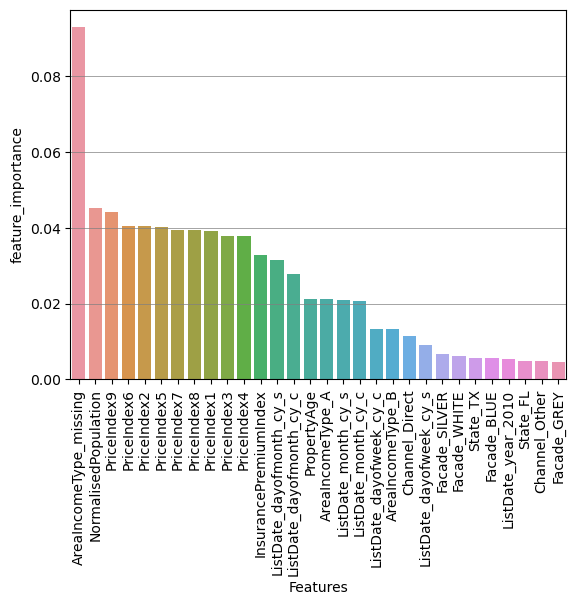

In [34]:
# importing libraries 
import seaborn as sns
import matplotlib.pyplot as plt

n= 30 # no of features
# creating the scatter plot with top 30 features and their importance score
sns.barplot(x='Features',y='feature_importance',
                data=df.head(30)).set_xticklabels(labels=df['Features'].head(30),rotation=90)
plt.grid(color = "grey", linewidth = "0.5",axis = 'y')
%matplotlib inline 

### Most important features in ascending order:

 'AreaIncomeType_missing',
 'NormalisedPopulation',
 'PriceIndex9',
 'PriceIndex5',
 'PriceIndex8',
 'PriceIndex6',
 'PriceIndex1',
 'PriceIndex7',
 'PriceIndex2',
 'PriceIndex4',
 'PriceIndex3',
 'InsurancePremiumIndex',
 'ListDate_dayofmonth_cy_s',
 'ListDate_dayofmonth_cy_c',
 'PropertyAge',
 'ListDate_month_cy_s',
 'ListDate_month_cy_c',
 'AreaIncomeType_A',
 'ListDate_dayofweek_cy_c',
 'AreaIncomeType_B'
 ####  'AreaIncomeType','PriceIndex', 'ListDate','InsurancePremiumIndex' and Property age plays importan.

In [35]:
## cross validation results report function.
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        # np.flatnonzero extracts index of `True` in a boolean array
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        
        for candidate in candidates:
             # print rank of the model
             # values passed to function format here are put in the curly brackets when printing
             # 0 , 1 etc refer to placeholder for position of values passed to format function
             # .3f means upto 3 decimal digits
            print("Model with rank: {0}".format(i))
            # this prints cross validate performance and its standard deviation
            print("Mean validation score: {0:.6f} (std: {1:.6f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            # prints the paramter combination for which this performance was obtained
            print("Parameters: {0}".format(results['params'][candidate]))
            # creates space b/w the output of each iteration
            print("") 

## Training , Evaluation and model selection:
### Logistic Regression:

In [36]:
from sklearn.model_selection import GridSearchCV ,RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

In [39]:
# hyper perametrs 
params={'penalty':['l1','l2'],'class_weight':['balanced',None],'C':np.linspace(0.01,100,100)}

# model
model_logr=LogisticRegression()

# evaluating the diffrent models performance
rs_logr=RandomizedSearchCV(model_logr,param_distributions=params,
                      scoring='roc_auc',cv=10,n_iter=40,n_jobs=-1,verbose=20) 

# training the model on standardised data( not modified data based on feature selected)
rs_logr.fit(x_train_std,y_train)

# performance of diffrent models
report(rs_logr.cv_results_) 

Fitting 10 folds for each of 40 candidates, totalling 400 fits
Model with rank: 1
Mean validation score: 0.763867 (std: 0.006827)
Parameters: {'penalty': 'l2', 'class_weight': 'balanced', 'C': 23.240000000000002}

Model with rank: 2
Mean validation score: 0.763867 (std: 0.006838)
Parameters: {'penalty': 'l2', 'class_weight': 'balanced', 'C': 8.09}

Model with rank: 3
Mean validation score: 0.763864 (std: 0.006838)
Parameters: {'penalty': 'l2', 'class_weight': 'balanced', 'C': 19.200000000000003}



In [40]:
# training the model with same parameters on standardised and featurselection data
rs_std_fs=RandomizedSearchCV(model_logr,param_distributions=params,
                             scoring='roc_auc',cv=10,
                             n_iter=40,n_jobs=-1,verbose=20) 

rs_std_fs.fit(X=x_train_std_fs,y=y_train) 

report(rs_std_fs.cv_results_,5)

Fitting 10 folds for each of 40 candidates, totalling 400 fits
Model with rank: 1
Mean validation score: 0.761682 (std: 0.006267)
Parameters: {'penalty': 'l2', 'class_weight': 'balanced', 'C': 74.75}

Model with rank: 2
Mean validation score: 0.761679 (std: 0.006269)
Parameters: {'penalty': 'l2', 'class_weight': 'balanced', 'C': 73.74000000000001}

Model with rank: 3
Mean validation score: 0.761676 (std: 0.006273)
Parameters: {'penalty': 'l2', 'class_weight': 'balanced', 'C': 79.80000000000001}

Model with rank: 4
Mean validation score: 0.761674 (std: 0.006264)
Parameters: {'penalty': 'l2', 'class_weight': 'balanced', 'C': 85.86}

Model with rank: 5
Mean validation score: 0.761672 (std: 0.006261)
Parameters: {'penalty': 'l2', 'class_weight': 'balanced', 'C': 52.53}



**Performance of the logistic regression model trined on full data(all features) and after dimensionality reduction with 95% information are approximately same.**

### Random Forest:

In [38]:
# saving RandomForest model in a object
rf=RandomForestClassifier(class_weight='balanced')
rf.get_params() 

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [39]:
# hyper parameters for RandomForest 
param_dist = {"n_estimators":[100,200,300,500],
              "max_features": [20,35,50,65,80,],
              'max_depth':[5,10,15,20,30,50,70,None],
                'min_samples_leaf':[20,30,40,50,70], 
                'min_samples_split':[30,45,60,75,90]}

# training the model on diffrent parameters
#(no of iterations should be 10 to 20 of total possible combinations)
random_search_rf=RandomizedSearchCV(rf,param_distributions=param_dist,
                                    cv=10,scoring='roc_auc',n_iter=30,
                                    n_jobs=-1,verbose=10) 
random_search_rf.fit(X=x_train_std,y=y_train)

# performance report of diffrent models with hyper-parameters
report(random_search_rf.cv_results_,3) 

Fitting 10 folds for each of 30 candidates, totalling 300 fits
Model with rank: 1
Mean validation score: 0.769191 (std: 0.007861)
Parameters: {'n_estimators': 300, 'min_samples_split': 75, 'min_samples_leaf': 20, 'max_features': 35, 'max_depth': 50}

Model with rank: 2
Mean validation score: 0.768663 (std: 0.007626)
Parameters: {'n_estimators': 500, 'min_samples_split': 60, 'min_samples_leaf': 30, 'max_features': 80, 'max_depth': 70}

Model with rank: 3
Mean validation score: 0.768463 (std: 0.007705)
Parameters: {'n_estimators': 300, 'min_samples_split': 75, 'min_samples_leaf': 20, 'max_features': 35, 'max_depth': None}



#### Sequenctial Tuning of XGBoost Classifier: 
- First we fix the parameters with most volatile performance (i.e no of trees or n_estimators, learning rate)

- Second controling the individual tree(weak learner):
             
             ## control the tree depth 
             - 'gamma'or 'min_split_loss': min loss reduction reqired to split (higher is conservative)
             - 'min_child_weight': minimum number of instances needed to be in each node(higher is conservative)
             - 'max_depth':max depth of individual tree (lower is better) 
             
             ## to avoid the noise in the data
             - 'subsample': subsampling ratio of training instances(0 to 1)
             - 'colsample_bytree': subsampling ratio of columns for each tree
             
- regularization parameters:

             - 'lambda': Ridge or L2
             - 'alpha': lasso or L1 

In [43]:
from xgboost.sklearn import XGBClassifier

In [49]:
# As learning rate is inversely proportional to no of estimators
# fixing the decent learning rate(0.1) and tuning for the no of estimators
xgb_params = { "n_estimators":[25,50,100,150,200,300,500] }

# storing the model in a object and searing the for best hyper parameters 
xgb1=XGBClassifier(learning_rate=0.1,subsample=0.8,colsample_bylevel=0.8,colsample_bytree=0.8)
grid_search_xgb1=GridSearchCV(xgb1,cv=10,param_grid=xgb_params,scoring='roc_auc',verbose=False,n_jobs=-1)

# traing the models on train data
grid_search_xgb1.fit(x_train_std_fs,y_train)

# performance of different models
report(grid_search_xgb1.cv_results_,3)

Model with rank: 1
Mean validation score: 0.774504 (std: 0.007654)
Parameters: {'n_estimators': 200}

Model with rank: 2
Mean validation score: 0.774464 (std: 0.008111)
Parameters: {'n_estimators': 150}

Model with rank: 3
Mean validation score: 0.774193 (std: 0.007798)
Parameters: {'n_estimators': 100}



**best parameters: ROC_AUC Score=0.7745**
- learning rate=0.1 
- n_estimators= 200 

In [53]:
# controling the individual tree to avoid overfiting
xgb_params = {"gamma":[0,2,5,8,10],
              "max_depth": [2,3,4,5,6,7,8],
              "min_child_weight":range(1,20)}

xgb2=XGBClassifier(n_estimators=200,learning_rate=0.1,
                   subsample=0.8,colsample_bylevel=0.8,colsample_bytree=0.8)

grid_search_xgb2=RandomizedSearchCV(xgb2,param_distributions=xgb_params,cv=10,n_iter=30,
                            scoring='roc_auc',verbose=False,n_jobs=-1)

grid_search_xgb2.fit(x_train_std_fs,y_train)

report(grid_search_xgb2.cv_results_,3) 

Model with rank: 1
Mean validation score: 0.776147 (std: 0.007998)
Parameters: {'min_child_weight': 7, 'max_depth': 5, 'gamma': 0}

Model with rank: 2
Mean validation score: 0.775276 (std: 0.007473)
Parameters: {'min_child_weight': 7, 'max_depth': 5, 'gamma': 2}

Model with rank: 3
Mean validation score: 0.775034 (std: 0.007571)
Parameters: {'min_child_weight': 10, 'max_depth': 4, 'gamma': 2}



**best parameters:ROC_AUC Score=0.7761**  
- learning rate=0.1,
- n_estimators= 200,
- min_child_weight=7,
- max_depth=5 
- gamma=0 .

In [57]:
# to avoid the noise in the data
xgb_params = {'subsample':[i/10 for i in range(5,11)],
            'colsample_bytree':[i/10 for i in range(5,11)]} 

xgb3=XGBClassifier( n_estimators=200,learning_rate=0.1,
                   min_child_weight=7, max_depth=5, gamma=0,  
                   subsample=0.8,colsample_bylevel=0.8,colsample_bytree=0.8)

grid_search_xgb3=RandomizedSearchCV(xgb3,param_distributions=xgb_params,cv=10,n_iter=30,
                            scoring='roc_auc',verbose=False,n_jobs=-1)

grid_search_xgb3.fit(x_train_std_fs,y_train)

report(grid_search_xgb3.cv_results_,3) 

Model with rank: 1
Mean validation score: 0.776476 (std: 0.008716)
Parameters: {'subsample': 0.8, 'colsample_bytree': 1.0}

Model with rank: 2
Mean validation score: 0.776204 (std: 0.007457)
Parameters: {'subsample': 1.0, 'colsample_bytree': 0.8}

Model with rank: 3
Mean validation score: 0.776147 (std: 0.007998)
Parameters: {'subsample': 0.8, 'colsample_bytree': 0.8}



**best parameters:ROC_AUC Score=0.7764**  
- learning rate=0.1,
- n_estimators= 200,
- min_child_weight=7,
- max_depth=5 
- gamma=0 
- subsample=0.8
- colsample_bytree=1

In [59]:
# regularization 
xgb_params={'reg_lambda':[i/10 for i in range(0,50,2)],
            'reg_alpha':[i/10 for i in range(0,50,2)]} 

xgb4=XGBClassifier( n_estimators=200,learning_rate=0.1,
                   min_child_weight=7, max_depth=5, gamma=0,  
                   subsample=0.8,colsample_bylevel=0.8,colsample_bytree=1)

grid_search_xgb4=RandomizedSearchCV(xgb4,param_distributions=xgb_params,cv=10,n_iter=30,
                            scoring='roc_auc',verbose=False,n_jobs=-1)

grid_search_xgb4.fit(x_train_std_fs,y_train)

report(grid_search_xgb4.cv_results_,3)  

Model with rank: 1
Mean validation score: 0.777492 (std: 0.008604)
Parameters: {'reg_lambda': 2.0, 'reg_alpha': 4.6}

Model with rank: 2
Mean validation score: 0.776799 (std: 0.008158)
Parameters: {'reg_lambda': 3.6, 'reg_alpha': 3.4}

Model with rank: 3
Mean validation score: 0.776786 (std: 0.007954)
Parameters: {'reg_lambda': 3.0, 'reg_alpha': 3.4}



In [60]:
# finl XGBoost model 
xgb5=grid_search_xgb4.best_estimator_

**best parameters:ROC_AUC Score=0.7775**  
- learning rate=0.1,
- n_estimators= 200,
- min_child_weight=7,
- max_depth=5 
- gamma=0 
- subsample=0.8
- colsample_bytree=1
- reg_lambda=2
- reg_alpha=4.6 

**till now best model is XGBoost Classifier. we predict the junk values using XGBoost Clasifier final model.**

In [66]:
# prdicting the 'Junk' feature values for test data
junk_pred_xgb=pd.DataFrame({'Junk': xgb5.predict(x_test_std_fs)})
junk_pred_xgb.to_csv('junk_pred_xgb.csv',index=False)

# count of junk classes 
junk_pred_xgb.value_counts() 

Junk
0       10560
1         388
Name: count, dtype: int64